TO VOXELS:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py 
from scipy.ndimage import binary_dilation #Q-score
from scipy.spatial.distance import cdist #Hausdorff Distance
from scipy.stats import wasserstein_distance #Wasserstein Distance
from scipy.ndimage import sobel #Gradient Magnitude Similarity Deviation

In [2]:
with h5py.File("train_point_clouds.h5", "r") as f:
    #all groups and datasets
    print("Keys in the HDF5 file:")
    print(list(f.keys())) 

Keys in the HDF5 file:
['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109

In [3]:
with h5py.File("train_point_clouds.h5", "r") as f:
    if isinstance(f['0'], h5py.Group):
        print("Keys in group '0':")
        print(list(f['0'].keys()))
    else:
        print("'0' is not a group, it may be a dataset")


Keys in group '0':
['img', 'normals', 'points']


In [4]:
# Load the train dataset
with h5py.File("train_point_clouds.h5", "r") as f:
    points_data_0 = f['0']['points'][:]  #load 3D points data for sample '0'
    points_data_1 = f['1']['points'][:]  #load 3D points data for sample '1'
    # print("Points data shape:", points_data_0.shape)
    # print("Points data contents:", points_data_0)


In [5]:
print("samlpe 0")
print("Points data shape:", points_data_0.shape)
print("Points data contents:", points_data_0)
print('\n')
print("samlpe 1")
print("Points data shape:", points_data_1.shape)
print("Points data contents:", points_data_1)

samlpe 0
Points data shape: (25700, 3)
Points data contents: [[ 0.15       -0.1094358   0.47305447]
 [ 0.15       -0.0969358   0.47305447]
 [ 0.15       -0.0844358   0.47305447]
 ...
 [ 0.15       -0.1094358  -0.50194553]
 [ 0.15       -0.1094358  -0.51444553]
 [ 0.15       -0.1094358  -0.52694553]]


samlpe 1
Points data shape: (26200, 3)
Points data contents: [[ 0.15        0.02270992  0.52146947]
 [ 0.15        0.03520992  0.52146947]
 [ 0.15        0.04770992  0.52146947]
 ...
 [ 0.15       -0.02729008 -0.45353053]
 [ 0.15       -0.02729008 -0.46603053]
 [ 0.15       -0.02729008 -0.47853053]]


In [6]:
def point_cloud_to_voxel_grid(point_cloud, grid_size=28):
    """
    Converts a point cloud to a voxel grid.
    
    Parameters:
    - point_cloud: (num_points, 3) numpy array of point coordinates.
    - grid_size: The size of the voxel grid (e.g., 28 for 28x28x28 grid).
    
    Returns:
    - voxel_grid: A 3D numpy array of shape (grid_size, grid_size, grid_size).
    """
    # Normalize point cloud to fit in a [0, 1] cube
    normalized_cloud = (point_cloud - point_cloud.min(axis=0)) / (point_cloud.ptp(axis=0))
    
    # Scale to grid size
    scaled_points = (normalized_cloud * (grid_size - 1)).astype(int)
    
    # Create an empty voxel grid
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=bool)
    
    # Fill the voxel grid
    voxel_grid[scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2]] = True
    
    return voxel_grid


In [7]:
def point_cloud_to_voxel_grid(point_cloud, grid_size=28):
    # Normalize point cloud to fit in a [0, 1] cube
    normalized_cloud = (point_cloud - point_cloud.min(axis=0)) / (point_cloud.ptp(axis=0))
    
    # Scale to grid size
    scaled_points = (normalized_cloud * (grid_size - 1)).astype(int)
    
    # Create an empty voxel grid
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=bool)
    
    # Fill the voxel grid
    voxel_grid[scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2]] = True
    
    return voxel_grid

# Convert the points data to a voxel grid
#voxel_grid = point_cloud_to_voxel_grid(points_data)
#print("Voxel grid shape:", voxel_grid.shape)


In [8]:
voxel_0 = point_cloud_to_voxel_grid(points_data_0)
voxel_1 = point_cloud_to_voxel_grid(points_data_1)
print('voxel_0 shape:', voxel_0.shape)
print('voxel_1 shape:', voxel_1.shape)

voxel_0 shape: (28, 28, 28)
voxel_1 shape: (28, 28, 28)


In [9]:
np.save("voxel_grid_sample_0.npy", voxel_0)
np.save("voxel_grid_sample_1.npy", voxel_1)

## If you have voxels saved run from HERE 

In [3]:
voxel_0 = np.load("voxel_grid_sample_0.npy")
voxel_1 = np.load("voxel_grid_sample_1.npy")


In [4]:
voxel_0

array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, Fal

In [5]:
voxel_1

array([[[False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [6]:
def plot_voxel(voxel_data, title="Voxel Grid"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, edgecolor="k")
    plt.title(title)
    plt.show()


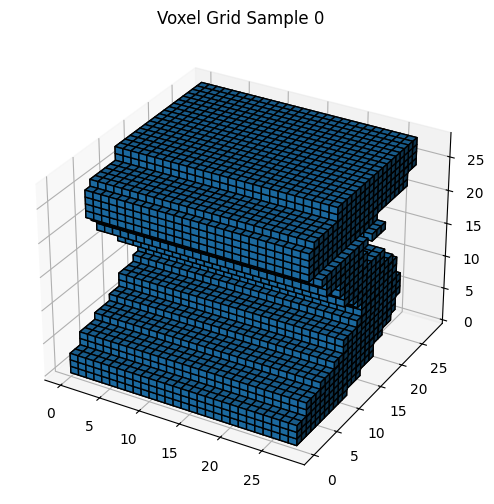

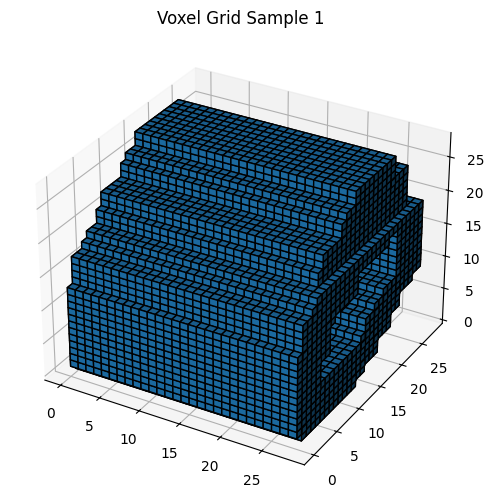

In [7]:
plot_voxel(voxel_0, title="Voxel Grid Sample 0")
plot_voxel(voxel_1, title="Voxel Grid Sample 1")

In [8]:
# Inverted voxel 0
inv_voxel_0 = np.logical_not(voxel_0)

# Comparing i.e. similarity measures

XOR -symmetric difference

In [9]:
# fraction of matching voxels by normalizing the XOR count to the total number of voxels
# The higher the value, the more similar the two voxel grids are between 0 and 1
def xor_similarity(voxel1, voxel2):
    xor_count = np.logical_xor(voxel1, voxel2).sum()
    total_voxels = voxel1.size
    return 1 - xor_count / total_voxels


In [10]:
xor_score = xor_similarity(voxel_0, voxel_0)
print("XOR similarity score between sample 0 and sample 0:", xor_score)

XOR similarity score between sample 0 and sample 0: 1.0


In [11]:
xor_score = xor_similarity(voxel_0, inv_voxel_0)
print("XOR similarity score between sample 0 and sample inv0:", xor_score)

XOR similarity score between sample 0 and sample inv0: 0.0


In [12]:
xor_score = xor_similarity(voxel_1, voxel_1)
print("XOR similarity score between sample 1 and sample 1:", xor_score)

XOR similarity score between sample 1 and sample 1: 1.0


In [13]:
xor_score = xor_similarity(voxel_0, voxel_1)
print("XOR similarity score between sample 0 and sample 1:", xor_score)

XOR similarity score between sample 0 and sample 1: 0.7042182944606414


In [14]:
xor_score = xor_similarity(voxel_1, voxel_0)
print("XOR similarity score between sample 1 and sample 0:", xor_score)

XOR similarity score between sample 1 and sample 0: 0.7042182944606414


## Hausdorff Distance
- Hausdorff Distance = 0: The grids are identical in terms of occupied voxel positions.<br>
- Hausdorff Distance > 0: Some voxels in one grid are not directly aligned with voxels in the other grid.

In [15]:
def hausdorff_distance(voxel1, voxel2):
    # Get coordinates of occupied voxels in both grids
    coords1 = np.array(np.nonzero(voxel1)).T
    coords2 = np.array(np.nonzero(voxel2)).T

    # Compute distances from each point in voxel1 to the closest point in voxel2
    dists_1_to_2 = cdist(coords1, coords2, 'euclidean').min(axis=1)
    dists_2_to_1 = cdist(coords2, coords1, 'euclidean').min(axis=1)

    # Hausdorff distance is the max of these minimum distances
    hausdorff_dist = max(dists_1_to_2.max(), dists_2_to_1.max())
    return hausdorff_dist

In [16]:
hausdorff_result = hausdorff_distance(voxel_0, voxel_0)
print("Hausdorff distance between sample 0 and sample 0:", hausdorff_result)

Hausdorff distance between sample 0 and sample 0: 0.0


In [17]:
hausdorff_result = hausdorff_distance(voxel_0, inv_voxel_0)
print("Hausdorff distance between sample 0 and sample inv0:", hausdorff_result)

Hausdorff distance between sample 0 and sample inv0: 8.48528137423857


In [18]:
hausdorff_result = hausdorff_distance(voxel_1, voxel_1)
print("Hausdorff distance between sample 1 and sample 1:", hausdorff_result)

Hausdorff distance between sample 1 and sample 1: 0.0


In [19]:
hausdorff_result = hausdorff_distance(voxel_0, voxel_1)
print("Hausdorff distance between sample 0 and sample 1:", hausdorff_result)

Hausdorff distance between sample 0 and sample 1: 8.246211251235321


In [20]:
hausdorff_result = hausdorff_distance(voxel_1, voxel_0)
print("Hausdorff distance between sample 1 and sample 0:", hausdorff_result)

Hausdorff distance between sample 1 and sample 0: 8.246211251235321


## Total Variation Distance
- Values range from 0 to 1.
- TVD = 0 means the voxel grids are identical (i.e., the two distributions are exactly the same).
- TVD = 1 represents the maximum possible difference (i.e., every voxel in one grid is different from the other).

In [21]:
def total_variation_distance(voxel1, voxel2):
    # Compute absolute difference and normalize
    abs_difference = np.abs(voxel1.astype(float) - voxel2.astype(float))
    tvd = np.sum(abs_difference) / (2 * voxel1.size)
    return tvd

In [22]:
tvd_result = total_variation_distance(voxel_0, voxel_0)
print("Total Variation Distance between sample 0 and sample 0:", tvd_result)

Total Variation Distance between sample 0 and sample 0: 0.0


In [23]:
tvd_result = total_variation_distance(voxel_1, voxel_1)
print("Total Variation Distance between sample 1 and sample 1:", tvd_result)

Total Variation Distance between sample 1 and sample 1: 0.0


In [24]:
tvd_result = total_variation_distance(voxel_0, voxel_1)
print("Total Variation Distance between sample 0 and sample 1:", tvd_result)

Total Variation Distance between sample 0 and sample 1: 0.1478908527696793


In [25]:
tvd_result = total_variation_distance(voxel_1, voxel_0)
print("Total Variation Distance between sample 1 and sample 0:", tvd_result)

Total Variation Distance between sample 1 and sample 0: 0.1478908527696793


## Wasserstein

In [26]:
def wasserstein_distance_voxel(voxel1, voxel2):
    # Flatten the voxel grids to 1D arrays
    voxel1_flat = voxel1.ravel().astype(float)
    voxel2_flat = voxel2.ravel().astype(float)
    
    # Compute Wasserstein distance
    wasserstein_dist = wasserstein_distance(voxel1_flat, voxel2_flat)
    return wasserstein_dist

In [27]:
wasserstein_result = wasserstein_distance_voxel(voxel_0, voxel_0)
print("Wasserstein distance between sample 0 and sample 0:", wasserstein_result)

Wasserstein distance between sample 0 and sample 0: 0.0


In [28]:
wasserstein_result = wasserstein_distance_voxel(voxel_1, voxel_1)
print("Wasserstein distance between sample 1 and sample 1:", wasserstein_result)

Wasserstein distance between sample 1 and sample 1: 0.0


In [29]:
wasserstein_result = wasserstein_distance_voxel(voxel_0, voxel_1)
print("Wasserstein distance between sample 0 and sample 1:", wasserstein_result)

Wasserstein distance between sample 0 and sample 1: 0.02619351311953355


In [30]:
wasserstein_result = wasserstein_distance_voxel(voxel_1, voxel_0)
print("Wasserstein distance between sample 1 and sample 0:", wasserstein_result)

Wasserstein distance between sample 1 and sample 0: 0.02619351311953355


## Gradient Magnitude Similarity Deviation

In [31]:
def gradient_magnitude_similarity_deviation(voxel1, voxel2):
    # Compute the gradient magnitude of each voxel grid
    gradient_magnitude1 = np.sqrt(sum(sobel(voxel1, axis=i)**2 for i in range(3)))
    gradient_magnitude2 = np.sqrt(sum(sobel(voxel2, axis=i)**2 for i in range(3)))
    
    # Compute the absolute difference of the gradient magnitudes
    gmsd = 1- np.mean(np.abs((gradient_magnitude1 - gradient_magnitude2) / (gradient_magnitude1 + gradient_magnitude2 + 1e-6)))
    return gmsd

In [32]:
GMSD_result = gradient_magnitude_similarity_deviation(voxel_0, voxel_0)
print("Gradient Magnitude Similarity Deviation between sample 0 and sample 0:", GMSD_result)

Gradient Magnitude Similarity Deviation between sample 0 and sample 0: 1.0


In [33]:
GMSD_result = gradient_magnitude_similarity_deviation(voxel_1, voxel_1)
print("Gradient Magnitude Similarity Deviation between sample 1 and sample 1:", GMSD_result)

Gradient Magnitude Similarity Deviation between sample 1 and sample 1: 1.0


In [34]:
GMSD_result = gradient_magnitude_similarity_deviation(voxel_0, voxel_1)
print("Gradient Magnitude Similarity Deviation between sample 0 and sample 1:", GMSD_result)

Gradient Magnitude Similarity Deviation between sample 0 and sample 1: 0.51025390625


In [35]:
GMSD_result = gradient_magnitude_similarity_deviation(voxel_1, voxel_0)
print("Gradient Magnitude Similarity Deviation between sample 1 and sample 0:", GMSD_result)

Gradient Magnitude Similarity Deviation between sample 1 and sample 0: 0.51025390625


In [36]:
GMSD_result = gradient_magnitude_similarity_deviation(voxel_0, inv_voxel_0)
print("Gradient Magnitude Similarity Deviation between sample 0 and sample inv0:", GMSD_result)
#######INTERESTING########

Gradient Magnitude Similarity Deviation between sample 0 and sample inv0: 1.0
